In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
import random
import chardet

## a)

In [4]:
df = pd.read_excel('sv.xlsx')

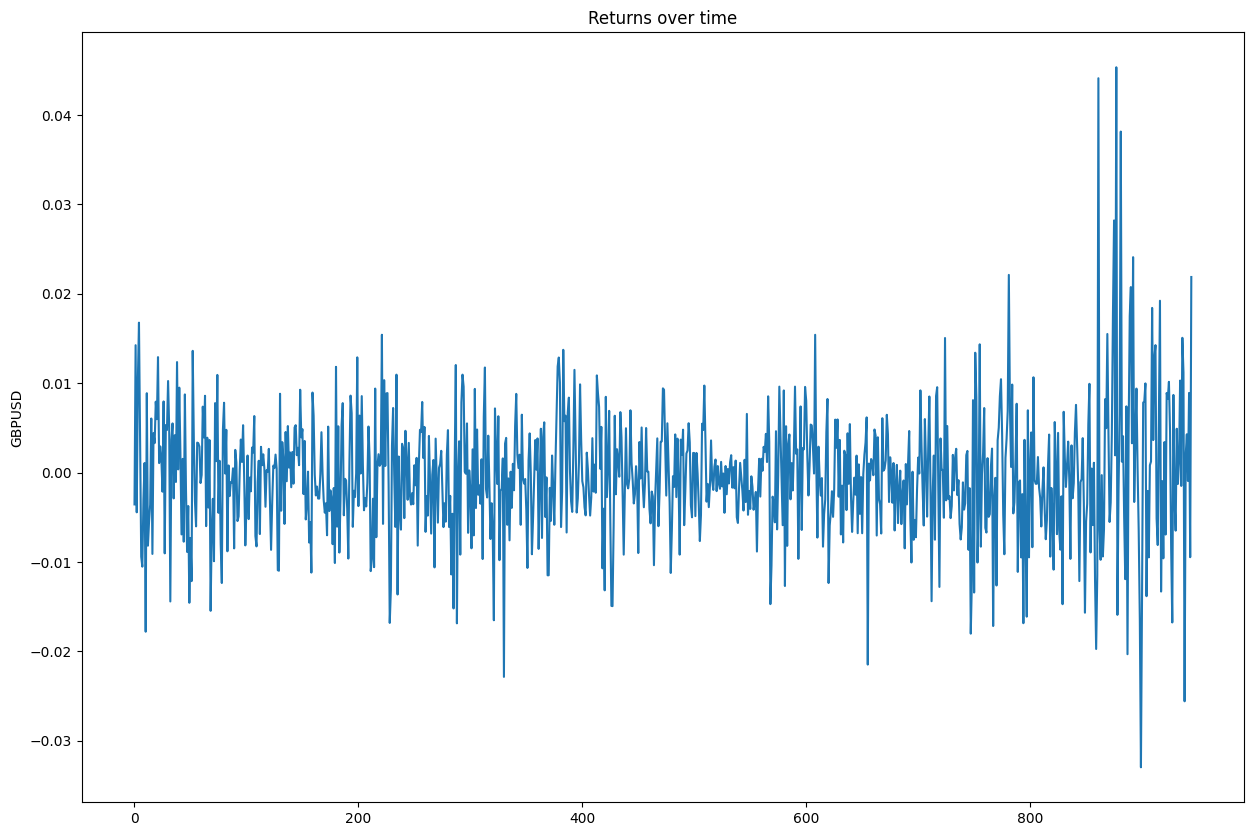

In [5]:
plt.figure(figsize=(15,10)) 
sns.lineplot(x=df.index, y=df['GBPUSD']/100)
plt.title("Returns over time")

plt.savefig('a_returns')

In [6]:
print(df['GBPUSD'].describe().to_latex(index=True))

\begin{tabular}{lr}
\toprule
{} &      GBPUSD \\
\midrule
count &  945.000000 \\
mean  &   -0.035310 \\
std   &    0.711089 \\
min   &   -3.296118 \\
25\%   &   -0.439391 \\
50\%   &   -0.045708 \\
75\%   &    0.364447 \\
max   &    4.534522 \\
\bottomrule
\end{tabular}



## b)

In [7]:
df['x'] = np.log( (df['GBPUSD'] - np.mean(df['GBPUSD']))**2)

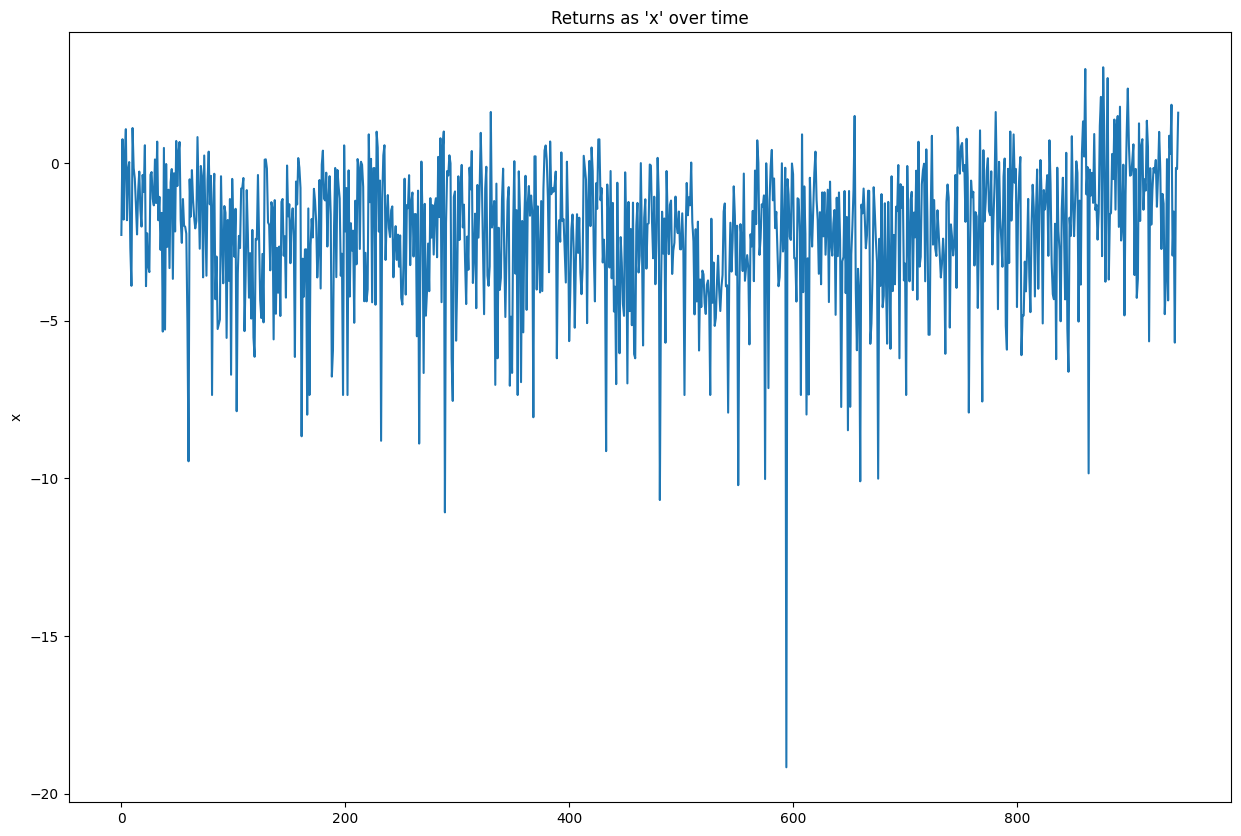

In [8]:

plt.figure(figsize=(15,10)) 

sns.lineplot(x=df.index, y=df['x'])

plt.title("Returns as 'x' over time")

plt.savefig('b_returns')

## c)

In [9]:
# For initialization typically take a1=0 and P1=10´7


def kalman_filter(df, variable, sigma_n, omega, phi):

    a_list_filtered =  [0] * len(df)
    a_list_predicted = [0] * (len(df)+1)
    P_list_filtered = [0] * len(df)
    P_list_predicted = [0] * (len(df)+1)
    v_list = [0] * len(df)
    F_list = [0] * len(df)
    K_list = [0] * len(df)
    x = df[variable]
    d = -1.27
    Z = 1 # Z = R = 1 by
    H = 4.93
    T = phi
    c = omega
    R = 1 
    Q = sigma_n


    for t in range(0,len(df)):
            
        if t == 0:
            
            # Defining initial values
            P0 = sigma_n/(1-phi**2)
            P_list_predicted[t] = P0

            a0 = omega/(1-phi)
            a_list_predicted[t] = a0


            # Components of the KF
            v = x[t] - Z * a_list_predicted[t] - d
            v_list[t] = v

            F  = Z * P_list_predicted[t] * Z + H
            F_list[t] = F

            K = T * P_list_predicted[t] * Z * 1/F_list[t]
            K_list[t] = K
            
            # Filtering Step
            a_filtered = a_list_predicted[t] + P_list_predicted[t] * Z * 1/F_list[t] * v_list[t]
            a_list_filtered[t] = a_filtered

            P_filtered = P_list_predicted[t] - P_list_predicted[t] * Z * 1/F_list[t] * Z * P_list_predicted[t]
            P_list_filtered[t] = P_filtered

            # Predicting Step
            a_pred = T * a_list_filtered[t] + c
            a_list_predicted[t+1] = a_pred

            P_pred = T * P_list_filtered[t] * T +  R * Q * R 
            P_list_predicted[t+1] = P_pred

        # Note that in Python the indexes start at 0 so t==1 is t=2 in the book and so on...
        
        else:

            # Components of the KF
            v = x[t] - Z *  a_list_predicted[t] - d
            v_list[t] = v

            F  = Z * P_list_predicted[t] * Z + H
            F_list[t] = F

            K = T * P_list_predicted[t] * Z * 1/F_list[t]
            K_list[t] = K
            
            # Filtering Step
            a_filtered = a_list_predicted[t] + P_list_predicted[t] * Z * 1/F_list[t] * v_list[t]
            a_list_filtered[t] = a_filtered

            P_filtered = P_list_predicted[t] - P_list_predicted[t] * Z * 1/F_list[t] * Z * P_list_predicted[t]
            P_list_filtered[t] = P_filtered

            # Predicting Step
            a_pred = T * a_list_filtered[t] + c
            a_list_predicted[t+1] = a_pred

            P_pred = T * P_list_filtered[t] * T +  R * Q * R
            P_list_predicted[t+1] = P_pred

    return a_list_filtered, P_list_filtered, a_list_predicted, P_list_predicted, v_list, F_list, K_list


In [10]:
phi = 0.9950 # from section 14.5.1
omega = (1-phi) * (np.mean(df['x']) + 1.27)
sigma_n = (1-phi**2) * (np.var(df['x']) - np.pi**2/2)


In [11]:
a_list_filtered, P_list_filtered, a_list_predicted, P_list_predicted, v_list, F_list, K_list = kalman_filter(df, 'x', sigma_n, omega, phi)

### KF optimization

In [12]:
def loglikelihood(theta, df):
     
    a_list_filtered =  [0] * len(df)
    a_list_predicted = [0] * (len(df)+1)
    P_list_filtered = [0] * len(df)
    P_list_predicted = [0] * (len(df)+1)
    v_list = [0] * len(df)
    F_list = [0] * len(df)
    K_list = [0] * len(df)
    x = df['x']
    d = -1.27
    Z = 1 # Z = R = 1 by
    H = 4.93
    T = theta[2]
    c = theta[1]
    R = 1 
    Q = theta[0]

    ll = 0
    ll_list = [ll]


    for t in range(0,len(df)):
            
        if t == 0:
            
            # Defining initial values
            P0 = theta[0]/(1-theta[2]**2)
            P_list_predicted[t] = P0

            a0 = theta[1]/(1-theta[2])
            a_list_predicted[t] = a0


            # Components of the KF
            v = x[t] - Z * a_list_predicted[t] - d
            v_list[t] = v

            F  = Z * P_list_predicted[t] * Z + H
            F_list[t] = F

            K = T * P_list_predicted[t] * Z * 1/F_list[t]
            K_list[t] = K
            
            # Filtering Step
            a_filtered = a_list_predicted[t] + P_list_predicted[t] * Z * 1/F_list[t] * v_list[t]
            a_list_filtered[t] = a_filtered

            P_filtered = P_list_predicted[t] - P_list_predicted[t] * Z * 1/F_list[t] * Z * P_list_predicted[t]
            P_list_filtered[t] = P_filtered

            # Predicting Step
            a_pred = T * a_list_filtered[t] + c
            a_list_predicted[t+1] = a_pred

            P_pred = T * P_list_filtered[t] * T +  R * Q * R 
            P_list_predicted[t+1] = P_pred

        # Note that in Python the indexes start at 0 so t==1 is t=2 in the book and so on...
        
        else:

            # Components of the KF
            v = x[t] - Z *  a_list_predicted[t] - d
            v_list[t] = v

            F  = Z * P_list_predicted[t] * Z + H
            F_list[t] = F

            K = T * P_list_predicted[t] * Z * 1/F_list[t]
            K_list[t] = K
            
            # Filtering Step
            a_filtered = a_list_predicted[t] + P_list_predicted[t] * Z * 1/F_list[t] * v_list[t]
            a_list_filtered[t] = a_filtered

            P_filtered = P_list_predicted[t] - P_list_predicted[t] * Z * 1/F_list[t] * Z * P_list_predicted[t]
            P_list_filtered[t] = P_filtered

            # Predicting Step
            a_pred = T * a_list_filtered[t] + c
            a_list_predicted[t+1] = a_pred

            P_pred = T * P_list_filtered[t] * T +  R * Q * R
            P_list_predicted[t+1] = P_pred
    

        
        # Write log likelihood
        ll += - 0.5 * np.log(2* np.pi) - 0.5 * (np.log(F_list[t]) + (v_list[t]**2/F_list[t]))
        ll_list.append(ll)

        
    return -ll


In [13]:
# Initial conditions
phi = 0.9950 # from section 14.5.1
omega = (1-phi) * (np.mean(df['x']) + 1.27)
sigma_n = (1-phi**2) * (np.var(df['x']) - np.pi**2/2)


theta0 = [sigma_n, omega, phi]



In [14]:
loglikelihood(theta0, df)

2089.799361421415

In [15]:

resultsQML = scipy.optimize.minimize(loglikelihood, theta0, args=(df,), method='L-BFGS-B', bounds=((0,  100000000), (-100000000, 10000000), (0,  0.999)))


In [16]:
print('parameter estimates:')
print(resultsQML.x)

print('log likelihood value:')
print(resultsQML.fun)

print('exit flag:')
print(resultsQML.success)

parameter estimates:
[ 0.00701683 -0.00698709  0.99121055]
log likelihood value:
2083.622099959209
exit flag:
True


Saving estimated parameters to dataframe 

In [66]:
data = [{'Estimated sigma eta': resultsQML.x[0], 'Estimated omega': resultsQML.x[1], 'Estimated phi': resultsQML.x[2]}]
estimated_c = pd.DataFrame(data, index=['Optimization results'])
print(estimated_c.to_latex(index=True))

\begin{tabular}{lrrr}
\toprule
{} &  Estimated sigma eta &  Estimated omega &  Estimated phi \\
\midrule
Optimization results &             0.085584 &        -0.252353 &       0.974788 \\
\bottomrule
\end{tabular}



## d)

In [17]:
a_list_filteredQML, P_list_filtered, a_list_predicted, P_list_predicted, v_list, F_list, K_list = kalman_filter(df, 'x', resultsQML.x[0], resultsQML.x[1], resultsQML.x[2])

In [18]:

#Initialization r=N=0
def smoother(df, variable, sigma_n, omega, phi):

  a_list_filtered, P_list_filtered, a_list_predicted, P_list_predicted, v_list, F_list, K_list = kalman_filter(df, variable, sigma_n, omega, phi)

  r_list = [0] * (len(df)+1)
  N_list = [0] * (len(df)+1)
  V_list = [0] * len(df)
  L_list = [0] * len(df)
  alpha_list = [0] * len(df)
  T = phi
  c = omega
  Q = sigma_n
  x = df
  d = -1.27
  Z = 1 # Z = R = 1 by
  H = 4.93
  R = 1 

  for t in reversed(range(0,len(df))):
  
    if t==944:

        r_0 = 0
        r_list[t+1] = r_0

        N_0 = 0
        N_list[t+1] = N_0 

        L = T - K_list[t] * Z
        L_list[t] = L

        r = Z * F_list[t]**-1 * v_list[t] + L_list[t] * r_list[t+1]
        r_list[t] = r

        N = Z * F_list[t]**-1 * Z + L_list[t] * N_list[t+1] * L_list[t]
        N_list[t] = N

        alpha = a_list_predicted[t] + P_list_predicted[t] * r_list[t]
        alpha_list[t] = alpha

        V = P_list_predicted[t] - P_list_predicted[t] * N_list[t] * P_list_predicted[t]
        V_list[t] = V

    else: 
        
        L = T - K_list[t] * Z
        L_list[t] = L

        r = Z * F_list[t]**-1 * v_list[t] + L_list[t] * r_list[t+1]
        r_list[t] = r

        N = Z * F_list[t]**-1 * Z + L_list[t] * N_list[t+1] * L_list[t]
        N_list[t] = N

        alpha = a_list_predicted[t] + P_list_predicted[t] * r_list[t]
        alpha_list[t] = alpha

        V = P_list_predicted[t] - P_list_predicted[t] * N_list[t] * P_list_predicted[t]
        V_list[t] = V

        
  return r_list, N_list, alpha_list, V_list

  

In [19]:
r_list, N_list, alpha_list, V_list = smoother(df, 'x', resultsQML.x[0], resultsQML.x[1], resultsQML.x[2])

Now we calculate filtered H and smoothed H, by substracting 'xi'

In [21]:
# Calculate xi variable using the estimated parameters
xi = resultsQML.x[1]/(1-resultsQML.x[2]) 
xi

-0.7949406197139403

In [22]:
# Calculate filtered H

h_filtered = a_list_predicted
h_tilde_filtered = a_list_predicted - xi

In [23]:

h_tilde_filtered = a_list_predicted - xi
# Calculate smoothed H

h_smoothed = alpha_list
h_tilde_smoothed = alpha_list - xi

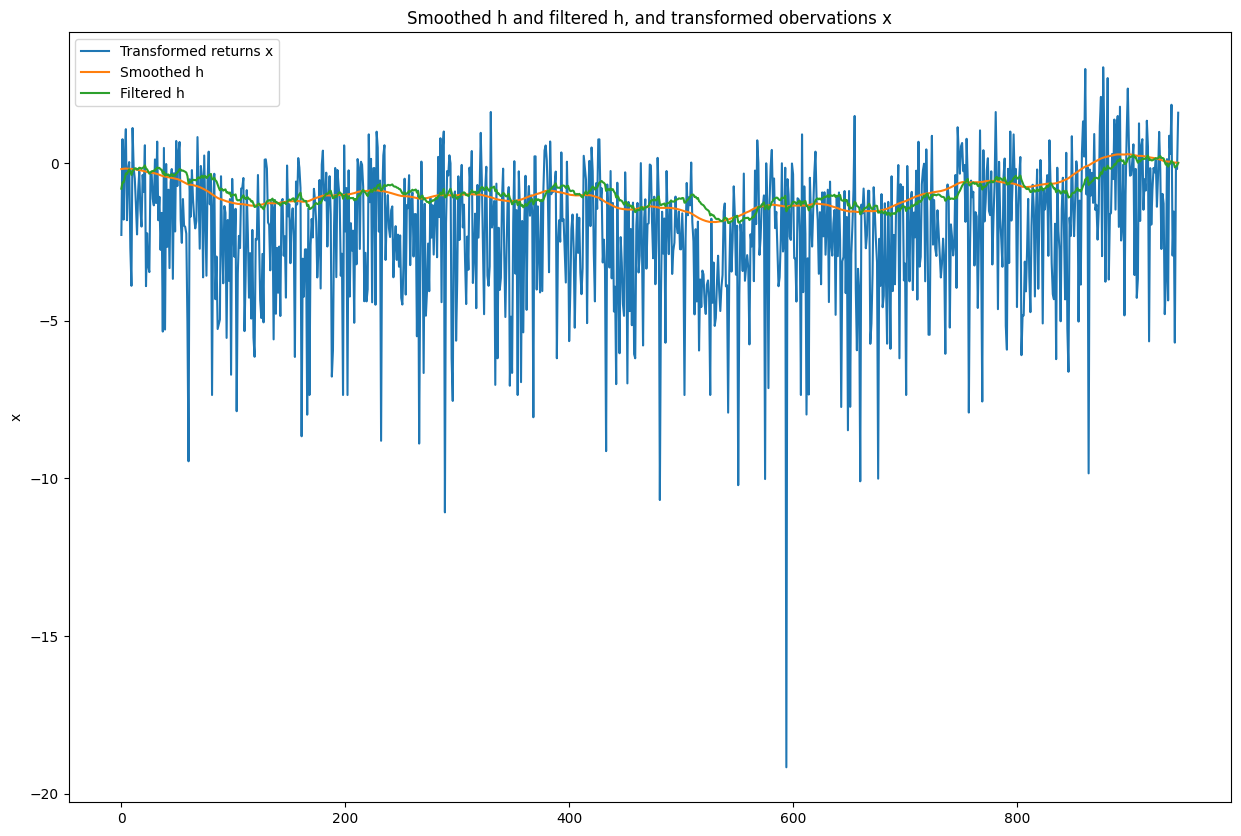

In [25]:
plt.figure(figsize=(15,10)) 

sns.lineplot(x=df.index, y=df['x'], label='Transformed returns x')
sns.lineplot(x=df.index, y=h_smoothed, label='Smoothed h')
sns.lineplot(x=df.index, y=h_filtered[1:], label='Filtered h')


plt.legend()
plt.title("Smoothed h and filtered h, and transformed obervations x")

plt.savefig('h_smoothed')

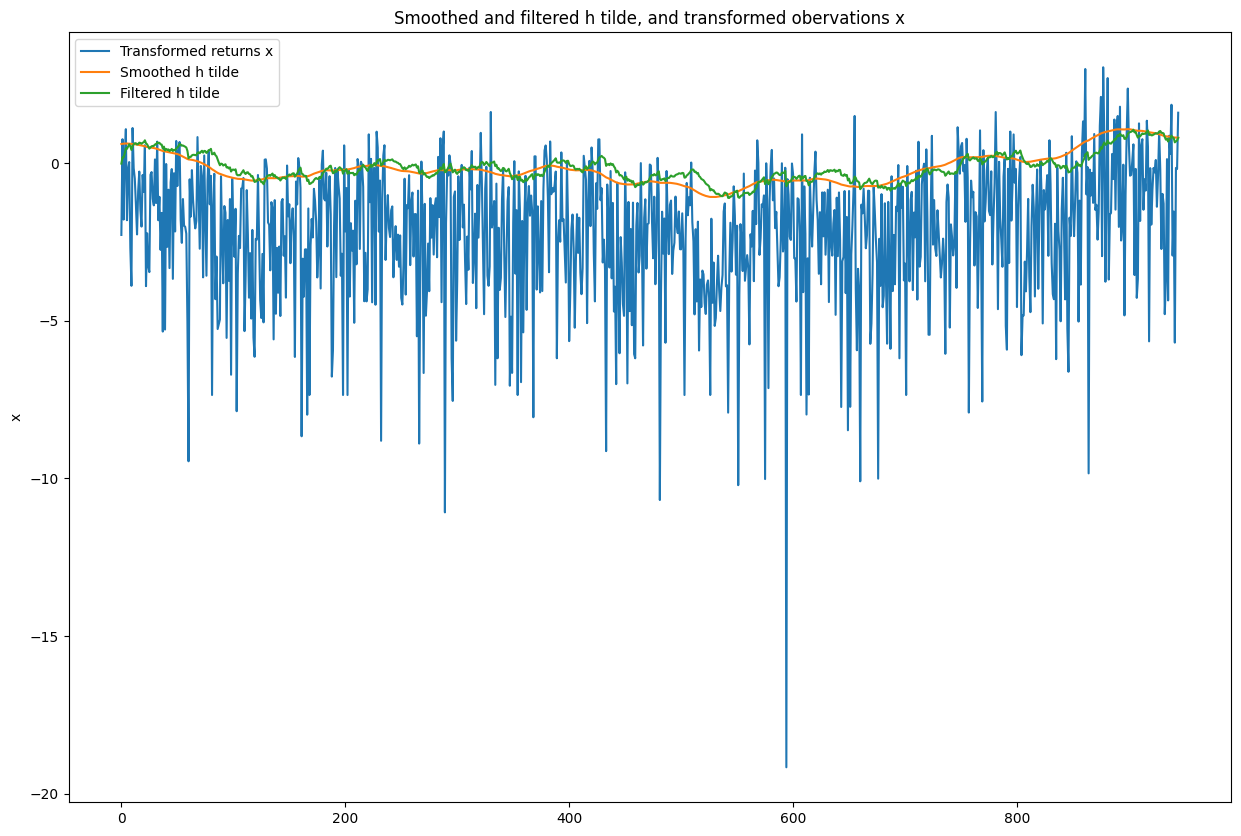

In [26]:
plt.figure(figsize=(15,10)) 

sns.lineplot(x=df.index, y=df['x'], label='Transformed returns x')
sns.lineplot(x=df.index, y=h_tilde_smoothed, label='Smoothed h tilde')
sns.lineplot(x=df.index, y=h_tilde_filtered[1:], label='Filtered h tilde')

plt.title("Smoothed and filtered h tilde, and transformed obervations x")

plt.savefig('h_filtered')

In [ ]:
print(np.mean(h))
print(np.mean(a_list_filtered))
print(np.median(df['x']))

-0.9635298832406974
-0.9381339208433105
-1.8326366497830648


# Question e:


In [27]:
rv  = pd.read_csv('rv.csv')

In [28]:
rv['date'] = pd.to_datetime(rv['date'], utc=True).dt.date

In [29]:
start =  pd.to_datetime('2016-01-01')
end= pd.to_datetime('2020-12-31')

filter = (rv['date'] >= start) & (rv['date'] <= end)
rv = rv.loc[filter]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [30]:
rv = rv[rv['Symbol'] == '.SPX']

### Calculate the two input variables for the kalman filter

In [31]:
# Returns y

rv['y'] = np.log(rv['close_price']/rv['close_price'].shift(1))

In [32]:
# Log(rv)-1,27

rv['log_rv_adjusted'] = np.log(rv['rv5'])-1.27

## 1) We re-run the steps from a) to d) over the new return data, to estimate the parameters

a)


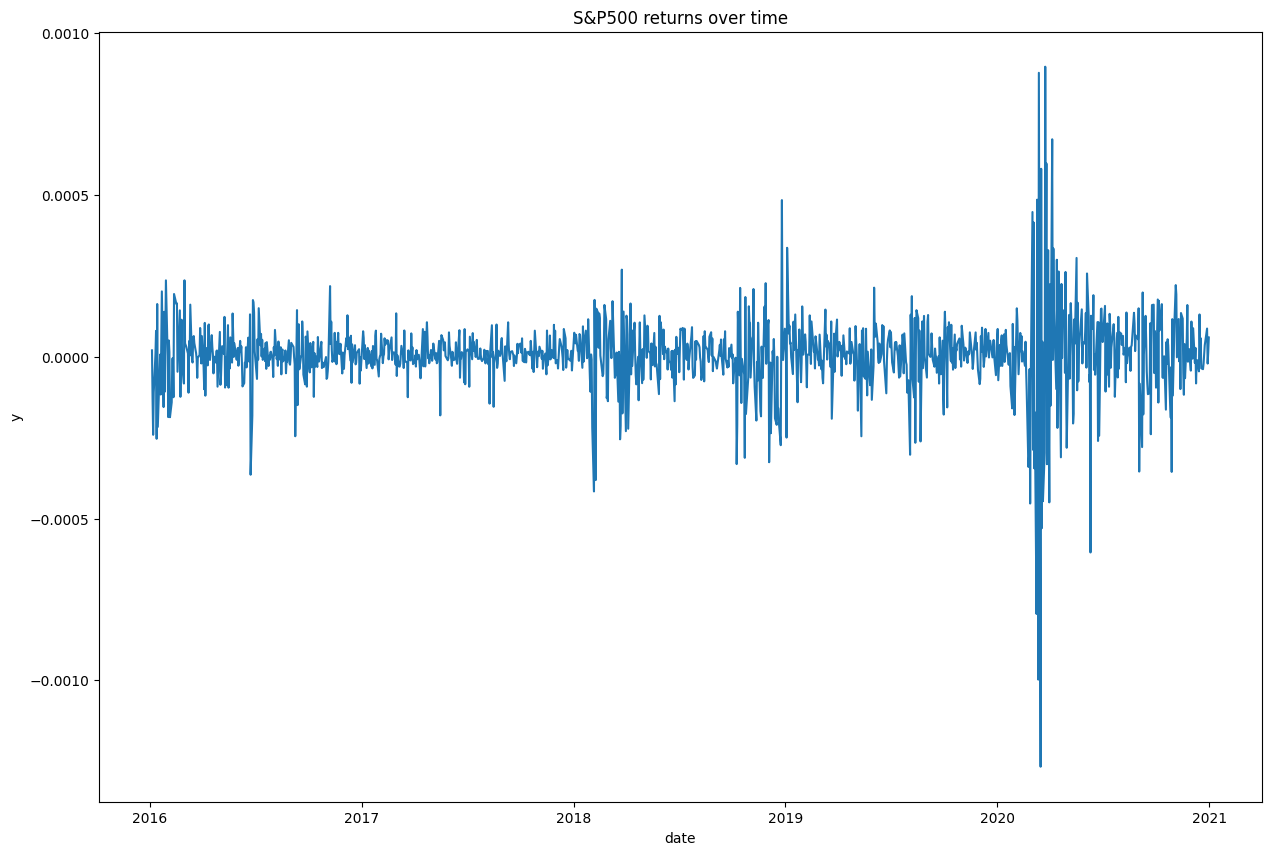

In [33]:
plt.figure(figsize=(15,10)) 
sns.lineplot(x=rv.date, y=rv['y']/100)
plt.title("S&P500 returns over time")

plt.savefig('s&p_a)')

In [56]:
print(rv['y'].describe().to_latex(index=True))

\begin{tabular}{lr}
\toprule
{} &            y \\
\midrule
count &  1249.000000 \\
mean  &     0.000499 \\
std   &     0.012177 \\
min   &    -0.126703 \\
25\%   &    -0.002895 \\
50\%   &     0.000707 \\
75\%   &     0.005373 \\
max   &     0.089612 \\
\bottomrule
\end{tabular}



b)

In [34]:
rv['x'] = np.log( (rv['y'] - np.mean(rv['y']))**2)

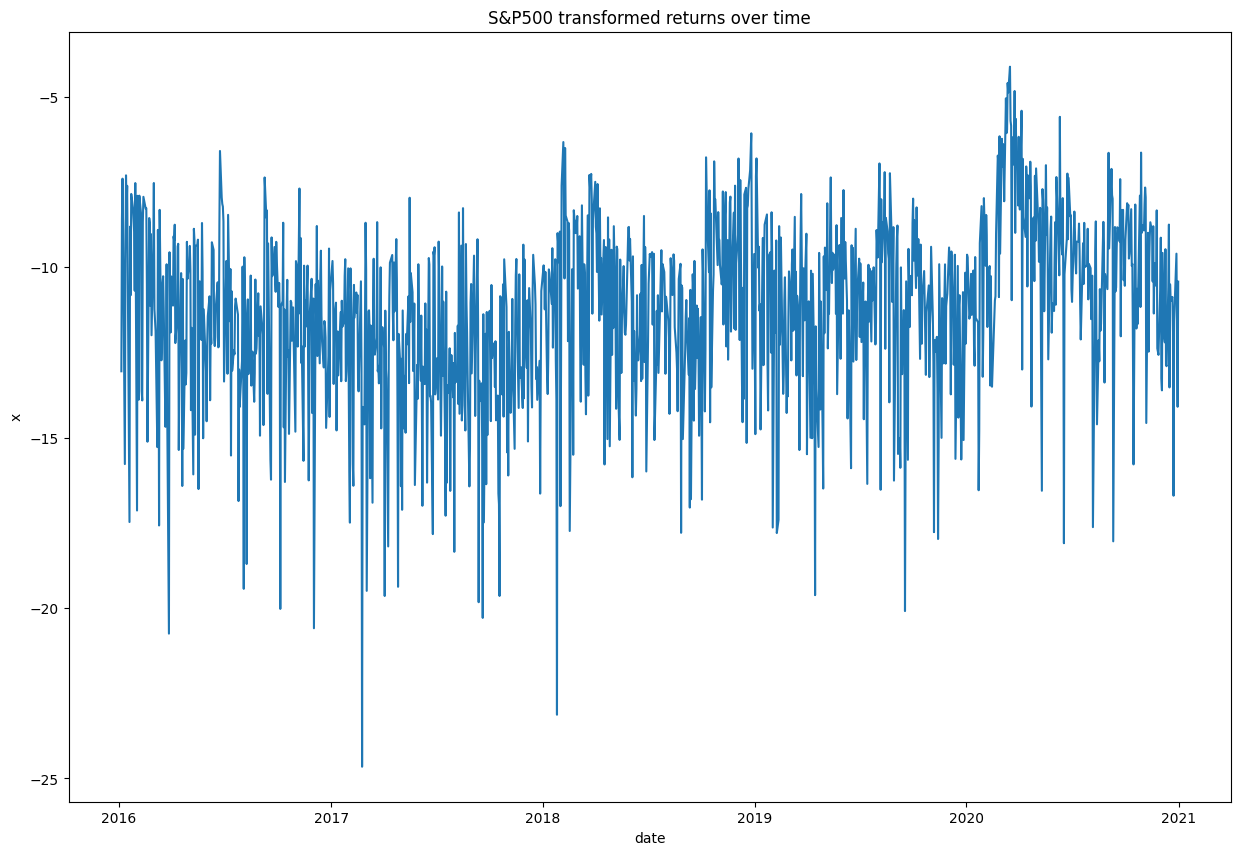

In [35]:
plt.figure(figsize=(15,10)) 

sns.lineplot(x=rv.date, y=rv['x'])

plt.title("S&P500 transformed returns over time")

plt.savefig('s&p_b)')

c)

In [36]:
rv = rv.iloc[1:,:].reset_index(drop=True)

In [37]:
# Initial conditions
phi_extended = 0.9950 # from section 14.5.1
omega_extended = (1-phi) * (np.mean(rv['x']) + 1.27) 
sigma_n_extended = (1-phi**2) * (np.var(rv['x']) - np.pi**2/2)


theta0_extended = [sigma_n_extended, omega_extended, phi_extended]

In [38]:
results_extended = scipy.optimize.minimize(loglikelihood, theta0_extended, args=(rv,), method='L-BFGS-B', bounds=((0,  100000000), (-100000000, 10000000), (0,  0.999)))

In [39]:
print('parameter estimates:')
print(results_extended.x)

print('log likelihood value:')
print(results_extended.fun)

print('exit flag:')
print(results_extended.success)

parameter estimates:
[ 0.08558426 -0.25235285  0.9747877 ]
log likelihood value:
2874.093050860068
exit flag:
True


In [40]:
data = [{'Estimated sigma eta': results_extended.x[0], 'Estimated omega': results_extended.x[1], 'Estimated phi': results_extended.x[2]}]
estimated_c = pd.DataFrame(data, index=['Optimization results'])
print(estimated_c.to_latex(index=True))

\begin{tabular}{lrrr}
\toprule
{} &  Estimated sigma eta &  Estimated omega &  Estimated phi \\
\midrule
Optimization results &             0.085584 &        -0.252353 &       0.974788 \\
\bottomrule
\end{tabular}



d)

In [46]:
a_list_filtered, P_list_filtered, a_list_predicted, P_list_predicted, v_list, F_list, K_list = kalman_filter(rv, 'x', results_extended.x[0], results_extended.x[1], results_extended.x[2])

In [47]:
r_list, N_list, alpha_list, V_list = smoother(rv, 'x', results_extended.x[0], results_extended.x[1], results_extended.x[2])

In [48]:
# Create dataframe to save results
results_original_model = pd.DataFrame()

In [55]:
# Save results to dataframe


results_original_model['a_list_filtered'] = a_list_filtered

results_original_model['P_list_filtered'] =P_list_filtered
results_original_model['a_list_predicted']=a_list_predicted[1:]
results_original_model['P_list_predicted']=P_list_predicted[1:]
results_original_model['v_list']=v_list
results_original_model['F_list']=F_list
results_original_model['K_list']=K_list
results_original_model['r_list']=r_list[1:]
results_original_model['N_list']=N_list[1:]
results_original_model['alpha_list']=alpha_list
results_original_model['V_list']=V_list


In [56]:
# Calculate xi variable using the estimated parameters
xi = results_extended.x[1]/(1-results_extended.x[2]) 
xi

-10.009116054385407

In [57]:
# Calculate filtered H

h_filtered = a_list_predicted
h_tilde_filtered = a_list_predicted - xi

In [58]:
# Calculate smoothed H

h_smoothed = alpha_list
h_tilde_smoothed = alpha_list - xi

In [59]:
# Save results to dataframe

results_original_model['h_filtered']=a_list_predicted[1:]
results_original_model['h_tilde_filtered']=h_tilde_filtered[1:]
results_original_model['h_smoothed']=alpha_list
results_original_model['h_tilde_smoothed']=h_tilde_smoothed

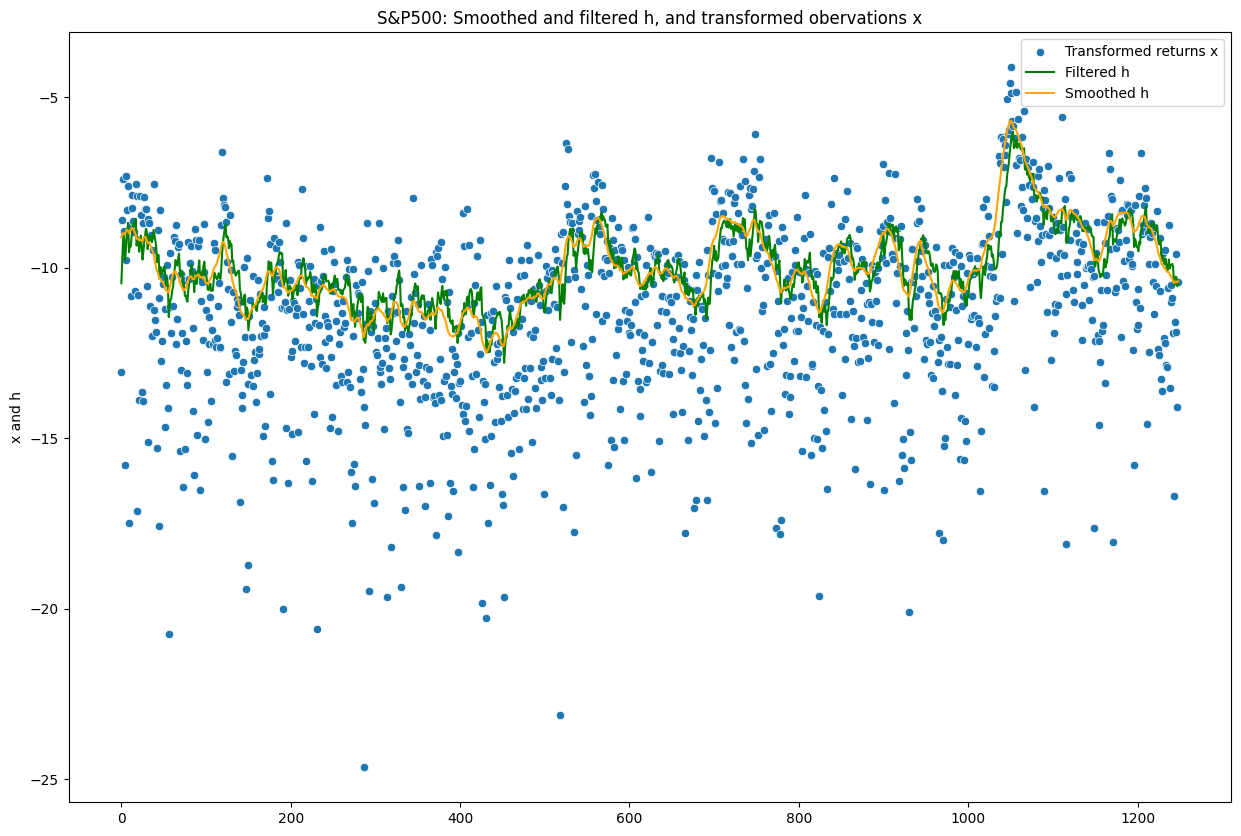

In [71]:
plt.figure(figsize=(15,10)) 

sns.scatterplot(x=rv.index, y=rv['x'], label='Transformed returns x')
sns.lineplot(x=rv.index, y=results_original_model['h_filtered'], label='Filtered h', color='g')
sns.lineplot(x=rv.index, y=results_original_model['h_smoothed'], label='Smoothed h', color='orange')

plt.title("S&P500: Smoothed and filtered h, and transformed obervations x")
plt.ylabel('x and h')

plt.savefig('s&p_h_filtered_smoothed')

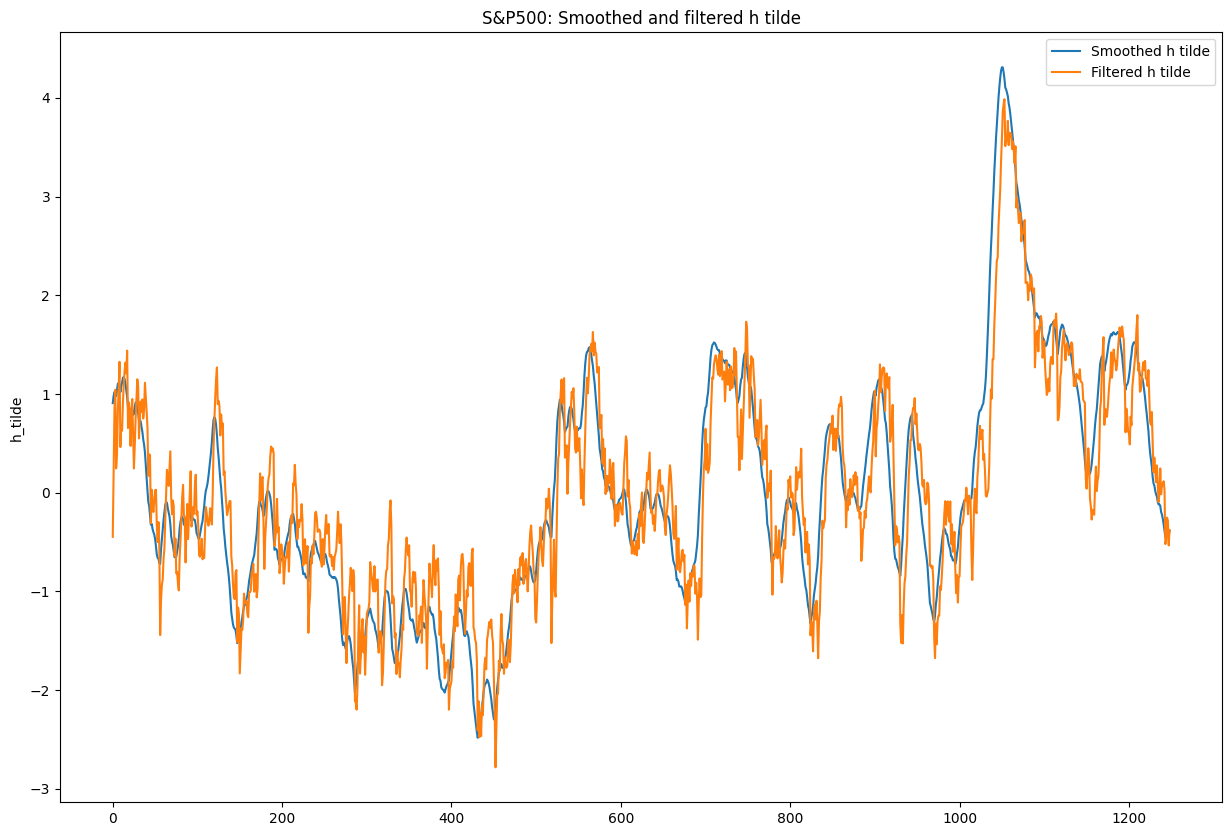

In [72]:
plt.figure(figsize=(15,10)) 

sns.lineplot(x=rv.index, y=results_original_model['h_tilde_smoothed'], label='Smoothed h tilde')
sns.lineplot(x=rv.index, y=results_original_model['h_tilde_filtered'], label='Filtered h tilde')

plt.ylabel('h_tilde')
plt.title("S&P500: Smoothed and filtered h tilde")

plt.savefig('s&p_h_tilde_filtered_smoothed')

In [219]:
x_original_estimated = alpha_list

## Extended model

## 1) We run KF over the returns, using the estimated parameters, to get v* and F


In [220]:
# For initialization typically take a1=0 and P1=10´7

def kalman_filter_step1(df, sigma_n, omega, phi):

    a_list_filtered =  [0] * len(df)
    a_list_predicted = [0] * (len(df)+1)
    P_list_filtered = [0] * len(df)
    P_list_predicted = [0] * (len(df)+1)
    v_list_star = [0] * len(df)
    F_list = [0] * len(df)
    K_list = [0] * len(df)
    x = df['x']
    d = -1.27
    Z = 1 # Z = R = 1 by
    H = 4.93
    T = phi
    c = omega
    R = 1 
    Q = sigma_n


    for t in range(0,len(df)):
            
        if t == 0:
            
            # Defining initial values
            P0 = sigma_n/(1-phi**2)
            P_list_predicted[t] = P0

            a0 = omega/(1-phi)
            a_list_predicted[t] = a0


            # Components of the KF
            v_star = x[t] - Z * a_list_predicted[t] - d
            v_list_star[t] = v_star

            F  = Z * P_list_predicted[t] * Z + H
            F_list[t] = F

            K = T * P_list_predicted[t] * Z * 1/F_list[t]
            K_list[t] = K
            
            # Filtering Step
            a_filtered = a_list_predicted[t] + P_list_predicted[t] * Z * 1/F_list[t] * v_list_star[t]
            a_list_filtered[t] = a_filtered

            P_filtered = P_list_predicted[t] - P_list_predicted[t] * Z * 1/F_list[t] * Z * P_list_predicted[t]
            P_list_filtered[t] = P_filtered

            # Predicting Step
            a_pred = T * a_list_filtered[t] + c
            a_list_predicted[t+1] = a_pred

            P_pred = T * P_list_filtered[t] * T +  R * Q * R 
            P_list_predicted[t+1] = P_pred

        # Note that in Python the indexes start at 0 so t==1 is t=2 in the book and so on...
        
        else:

            # Components of the KF
            v_star = x[t] - Z *  a_list_predicted[t] - d
            v_list_star[t] = v_star

            F  = Z * P_list_predicted[t] * Z + H
            F_list[t] = F

            K = T * P_list_predicted[t] * Z * 1/F_list[t]
            K_list[t] = K
            
            # Filtering Step
            a_filtered = a_list_predicted[t] + P_list_predicted[t] * Z * 1/F_list[t] * v_list_star[t]
            a_list_filtered[t] = a_filtered

            P_filtered = P_list_predicted[t] - P_list_predicted[t] * Z * 1/F_list[t] * Z * P_list_predicted[t]
            P_list_filtered[t] = P_filtered

            # Predicting Step
            a_pred = T * a_list_filtered[t] + c
            a_list_predicted[t+1] = a_pred

            P_pred = T * P_list_filtered[t] * T +  R * Q * R
            P_list_predicted[t+1] = P_pred

    return a_list_filtered, P_list_filtered, a_list_predicted, P_list_predicted, v_list_star, F_list, K_list


In [221]:
opt_sigma_n = results_extended.x[0]
opt_omega = results_extended.x[1]
opt_phi = results_extended.x[2]

In [222]:
a_list_filtered, P_list_filtered, a_list_predicted, P_list_predicted, v_list_star, F_list_star, K_list = kalman_filter_step1(rv, opt_sigma_n, opt_omega, opt_phi)

## 2) We run KF over log_rv_adjusted to get X*

In [ ]:
# if the plot is more straight, it means that the model captures better the data and the variabnce is better captured because its smaller.
# beta shoul be positive (captures the variance, it improves), if its higher then better.

In [175]:
# For initialization typically take a1=0 and P1=10´7

def kalman_filter_step2(df, sigma_n, omega, phi):

    a_list_filtered =  [0] * len(df)
    a_list_predicted = [0] * (len(df)+1)
    P_list_filtered = [0] * len(df)
    P_list_predicted = [0] * (len(df)+1)
    x_list_star = [0] * len(df)
    F_list = [0] * len(df)
    K_list = [0] * len(df)
    rv_adj = df['log_rv_adjusted']
    d = -1.27
    Z = 1 # Z = R = 1 by
    H = 4.93
    T = phi
    c = omega
    R = 1 
    Q = sigma_n


    for t in range(0,len(df)):
            
        if t == 0:
            
            # Defining initial values
            P0 = sigma_n/(1-phi**2)
            P_list_predicted[t] = P0

            a0 = omega/(1-phi)
            a_list_predicted[t] = a0


            # Components of the KF
            x_star = rv_adj[t] - Z * a_list_predicted[t] - d
            x_list_star[t] = x_star

            F  = Z * P_list_predicted[t] * Z + H
            F_list[t] = F

            K = T * P_list_predicted[t] * Z * 1/F_list[t]
            K_list[t] = K
            
            # Filtering Step
            a_filtered = a_list_predicted[t] + P_list_predicted[t] * Z * 1/F_list[t] * v_list_star[t]
            a_list_filtered[t] = a_filtered

            P_filtered = P_list_predicted[t] - P_list_predicted[t] * Z * 1/F_list[t] * Z * P_list_predicted[t]
            P_list_filtered[t] = P_filtered

            # Predicting Step
            a_pred = T * a_list_filtered[t] + c
            a_list_predicted[t+1] = a_pred

            P_pred = T * P_list_filtered[t] * T +  R * Q * R 
            P_list_predicted[t+1] = P_pred

        # Note that in Python the indexes start at 0 so t==1 is t=2 in the book and so on...
        
        else:

            # Components of the KF
            x_star = rv_adj[t] - Z * a_list_predicted[t] - d
            x_list_star[t] = x_star
        
            F  = Z * P_list_predicted[t] * Z + H
            F_list[t] = F

            K = T * P_list_predicted[t] * Z * 1/F_list[t]
            K_list[t] = K
            
            # Filtering Step
            a_filtered = a_list_predicted[t] + P_list_predicted[t] * Z * 1/F_list[t] * v_list_star[t]
            a_list_filtered[t] = a_filtered

            P_filtered = P_list_predicted[t] - P_list_predicted[t] * Z * 1/F_list[t] * Z * P_list_predicted[t]
            P_list_filtered[t] = P_filtered

            # Predicting Step
            a_pred = T * a_list_filtered[t] + c
            a_list_predicted[t+1] = a_pred

            P_pred = T * P_list_filtered[t] * T +  R * Q * R
            P_list_predicted[t+1] = P_pred

    return a_list_filtered, P_list_filtered, a_list_predicted, P_list_predicted, x_list_star, F_list, K_list



In [176]:
a_list_filtered, P_list_filtered, a_list_predicted, P_list_predicted, X_list_star, F_list, K_list = kalman_filter_step2(rv, opt_sigma_n, opt_omega, opt_phi)

## 3) we compute the Beta

In [182]:
beta_df = pd.DataFrame()

beta_df['X_list_star'] = X_list_star
beta_df['F_list'] = F_list_star
beta_df['v_list_star'] = v_list_star

In [185]:
# first term of beta

beta_first_term = (beta_df['X_list_star'] * beta_df['X_list_star']) / beta_df['F_list']

beta_second_term = (beta_df['X_list_star'] * beta_df['v_list_star']) / beta_df['F_list']

beta = np.sum(beta_second_term) / np.sum(beta_first_term)

In [186]:
beta

0.7615018218214642

## 4) We re-run Kalman Filter over the observations: x-beta*log(RV)

In [438]:
rv['x_extended'] = rv['x'] - beta * np.log(rv['rv5'])

In [427]:
#rv['y_extended'] = rv['y'] - (beta * np.log(rv['rv5']))

In [439]:
a_list_filtered, P_list_filtered, a_list_predicted, P_list_predicted, v_list, F_list, K_list = kalman_filter(rv, 'x_extended', opt_sigma_n, opt_omega, opt_phi)

In [441]:
r_list, N_list, alpha_list, V_list = smoother(rv, 'x_extended', opt_sigma_n, opt_omega, opt_phi)

In [442]:
# Create dataframe to save results
results_extended_model = pd.DataFrame()

In [443]:
# Save results to dataframe

results_extended_model['a_list_filtered'] = a_list_filtered
results_extended_model['P_list_filtered'] =P_list_filtered
results_extended_model['a_list_predicted']=a_list_predicted[1:]
results_extended_model['P_list_predicted']=P_list_predicted[1:]
results_extended_model['v_list']=v_list
results_extended_model['F_list']=F_list
results_extended_model['K_list']=K_list
results_extended_model['r_list']=r_list[1:]
results_extended_model['N_list']=N_list[1:]
results_extended_model['alpha_list']=alpha_list
results_extended_model['V_list']=V_list


In [444]:
# Calculate xi variable using the estimated parameters
xi = opt_omega/(1-opt_phi)
xi

-10.015948120072514

In [445]:
# Calculate filtered H

h_filtered = results_extended_model['a_list_predicted']
h_tilde_filtered = results_extended_model['a_list_predicted'] - xi

In [446]:
# Calculate smoothed H

h_smoothed = results_extended_model['alpha_list']
h_tilde_smoothed = results_extended_model['alpha_list'] - xi

In [447]:
# Save results to dataframe

results_extended_model['h_filtered']= h_filtered
results_extended_model['h_tilde_filtered']=h_tilde_filtered
results_extended_model['h_smoothed']=h_smoothed
results_extended_model['h_tilde_smoothed']=h_tilde_smoothed

## Now we compare the original vs extended models

In [452]:
x_extended_estimated = (beta * np.log(rv['rv5'])) + results_extended_model['alpha_list']

In [475]:
x_original_estimated = results_original_model['alpha_list']

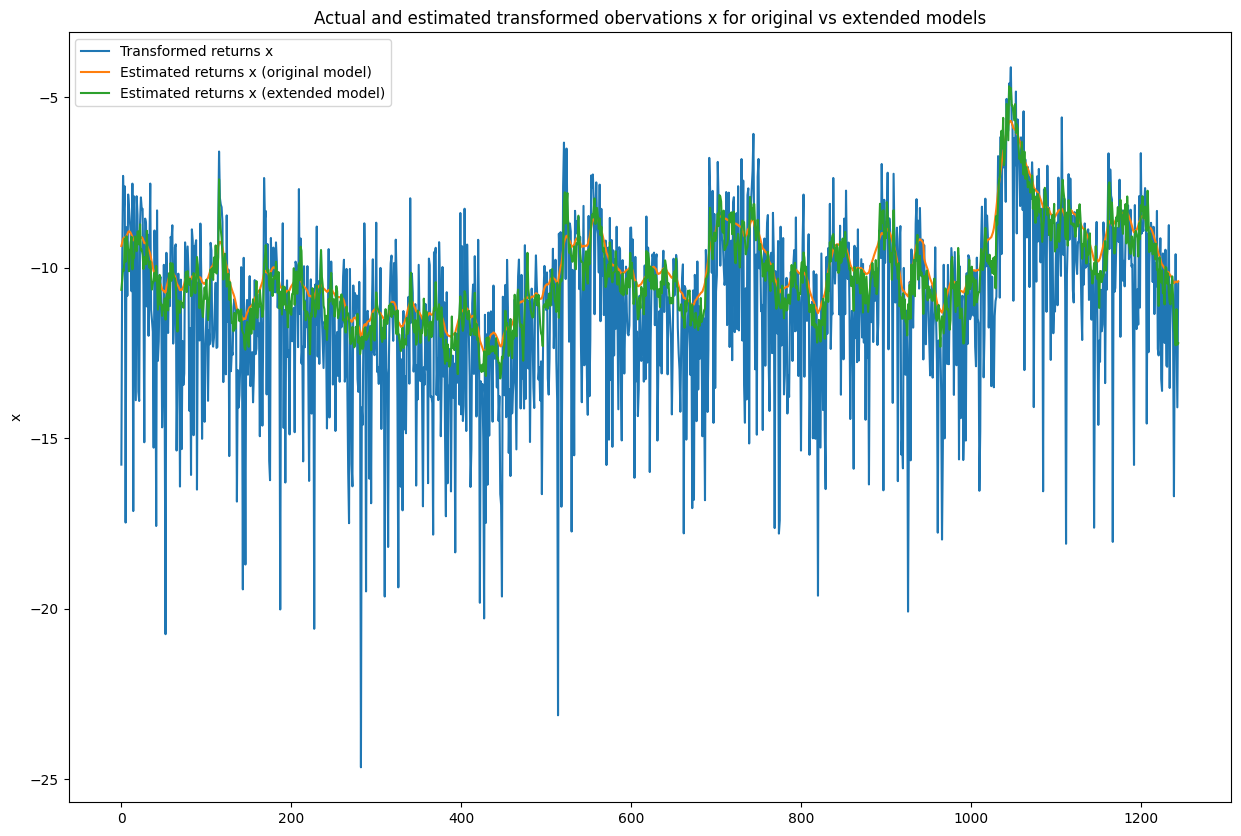

In [496]:
plt.figure(figsize=(15,10)) 

sns.lineplot(x=rv.index, y=rv['x'], label='Transformed returns x')
sns.lineplot(x=rv.index, y=x_original_estimated, label='Estimated returns x (original model)')
sns.lineplot(x=rv.index, y=x_extended_estimated, label='Estimated returns x (extended model)')

plt.legend()
plt.title("Actual and estimated transformed obervations x for original vs extended models")

plt.savefig('actual_vs_estimated_x')

## Calculate errors of estimation

In [478]:
erros_original_model = rv['x'] - x_original_estimated

In [479]:
erros_extended_model = rv['x'] - x_extended_estimated

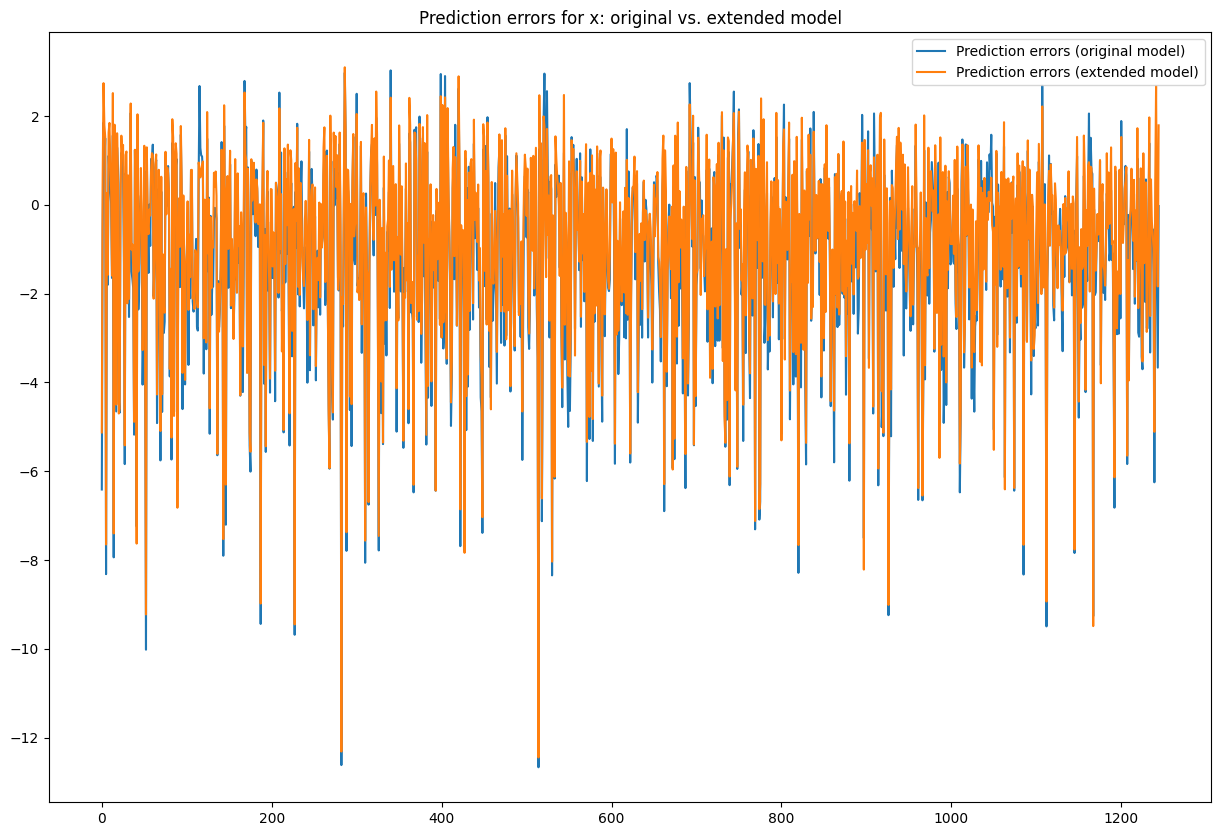

In [492]:
plt.figure(figsize=(15,10)) 

#sns.lineplot(x=rv.index, y=rv['x'], label='Transformed returns x')
sns.lineplot(x=rv.index, y=erros_original_model, label='Prediction errors (original model)')
sns.lineplot(x=rv.index, y=erros_extended_model, label='Prediction errors (extended model)')

plt.legend()
plt.title("Prediction errors for x: original vs. extended model")

plt.savefig('prediction_errors')

## Calculate error measure to compare the two models

In [481]:
# MSE

MSE_original_model = np.square(np.subtract(rv['x'], x_original_estimated)).mean() 
MSE_extended_model = np.square(np.subtract(rv['x'], x_extended_estimated)).mean() 

In [484]:
#RMSE 

RMSE_original_model = math.sqrt(MSE_original_model)
RMSE_extended_model = math.sqrt(MSE_extended_model)

In [508]:
errors = [{'MSE original model': MSE_original_model, 'MSE extended model': MSE_extended_model, 'RMSE original model': RMSE_original_model, 'RMSE extended model': RMSE_extended_model}]
errors = pd.DataFrame(errors, index=['Prediction errors'])
print(errors.to_latex(index=True))

\begin{tabular}{lrrrr}
\toprule
{} &  MSE original model &  MSE extended model &  RMSE original model &  RMSE extended model \\
\midrule
Prediction errors &            6.509721 &            5.590129 &             2.551416 &             2.364345 \\
\bottomrule
\end{tabular}



# Question f: Particle filter

In [224]:
phi = resultsQML.x[2]
sigma_n = resultsQML.x[0]
omega = resultsQML.x[1]
mu= np.mean(df['GBPUSD']) # mean of observations

In [225]:
def pdf_model1(y, signal, mu, xi): # Formula from book
    # This is the density P(yt|alpha_t_i_tilda)
    density =  math.exp(-0.5 * np.log(2 * np.pi) - 0.5 * (signal + xi) - 0.5 * (((y-mu)**2)/math.exp(signal+ xi)))  
    return density

In [226]:
def find_indices(list1, list2):
    indices = []
    for item in list1:
        try:
            index = list2.index(item)
            indices.append(index)
        except ValueError:
            pass
    return indices


In [236]:
def particle_filter(df, N, phi, sigma_n, mu, xi):
    T = len(df)
    # Create empty objects
    matrix_state = [[0 for _ in range(N)] for _ in range(T)]
    matrix_weights = [[0 for _ in range(N)] for _ in range(T)]
    matrix_weights_normalized = [[0 for _ in range(N)] for _ in range(T)]
    att_hat_list = [0] * T
    # Step 0: Initialize alpha and weights 
    alpha_0_i = np.random.normal(0, (sigma_n/(1-phi**2))**0.5, N) # Initialize using unconditional moments
    matrix_state[0] = alpha_0_i
    for i in range(0, N):
        matrix_weights[0][i] = pdf_model1(y = df['GBPUSD'][0], signal = matrix_state[0][i], mu = mu, xi = xi)

    # Normalize the weights and resample for initialization 
    for i in range(0, N):
        matrix_weights_normalized[0][i] = matrix_weights[0][i]/sum(matrix_weights[0])
        
    resampled_states = random.choices(population = matrix_state[0], weights = matrix_weights_normalized[0], k = N)
    matrix_state[0] = resampled_states
        
    # Step 1: Draw N values of alpha_t_i_tilda. Do this T-1 times (since we assume tau = 1)
    for j in range(1, T):
        att_hat_list_t = []
        
        for i in range(0, N):
            matrix_state[j][i] = np.random.normal(phi * matrix_state[j-1][i],sigma_n**0.5)
            # Step 2.1: compute the weights w_t_i_tilda
            matrix_weights[j][i] = pdf_model1(y = df['GBPUSD'][j], signal = matrix_state[j][i], mu = mu, xi = xi)
        # Step 2.2: Normalize the weights
        for i in range(0, N):
            matrix_weights_normalized[j][i] = matrix_weights[j][i]/sum(matrix_weights[j])
        # Step 3: compute att_hat and Ptt_hat
            att_hat = matrix_weights_normalized[j][i] * matrix_state[j][i]
            att_hat_list_t.append(att_hat)

        att_hat_list[j] = sum(att_hat_list_t)
        
        # Step 4: Resampling 
        resampled_states = random.choices(population = matrix_state[j], weights = matrix_weights_normalized[j], k = N)
        indices = find_indices(resampled_states, matrix_state[j])
        
        for i in indices: # This for loop is not necessary I think
            att_hat = matrix_weights_normalized[j][i] * matrix_state[j][i]
            att_hat_list_t.append(att_hat)

        
        matrix_state[j] = resampled_states
        
    
    

    return att_hat_list


In [237]:
att_hat_list = particle_filter(df, 1000, phi, sigma_n, mu, xi)

In [ ]:
plt.figure(figsize=(12,7)) 

sns.lineplot(att_hat_list[1:], label='Particle Filter')
sns.lineplot(a_list_filteredQML[1:] - xi, label='QML and Kalman Filter')
plt.title(r"Filtered estimates of $\tilde{h}_{t}$: QML and Kalman filter vs Particle Filter")
plt.xlabel('Time')
# add a legend that matches the line colors to the labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    label_color = handle.get_color()
    plt.setp(handle, color=label_color)
    plt.setp(handle.get_legend_handler(), mfc=label_color, mec=label_color)

# For SP500

In [ ]:
phi = results_extended.x[2]
sigma_n = results_extended.x[0]
omega = results_extended.x[1]
xi = results_extended.x[1]/(1-results_extended.x[2]) 
mu= np.mean(rv['y']) # mean of observations

In [ ]:
att_hat_list = particle_filter(rv, 1000, phi, sigma_n, mu, xi)

In [ ]:
plt.figure(figsize=(12,7)) 

sns.lineplot(x=rv.date[1:], y = att_hat_list[1:], label='Particle Filter')
sns.lineplot(x=rv.date[1:], y = a_list_filtered_extended[1:] - xi, label='QML and Kalman Filter')
plt.title(r"Filtered estimates of $\tilde{h}_{t}$: QML and Kalman filter vs Particle Filter for S&P500")
plt.xlabel('Time')
# add a legend that matches the line colors to the labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
for i, handle in enumerate(handles):
    label_color = handle.get_color()
    plt.setp(handle, color=label_color)
    plt.setp(handle.get_legend_handler(), mfc=label_color, mec=label_color)